In [3]:
all_event_wide_lists_withoutavg_1_8 <- readRDS("all_event_wide_lists_withoutavg_1_8.RDS")

In [4]:
library(dplyr)
library(tidyr)
library(stringr)
library(purrr)
library(ggplot2)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [5]:
#data_list <- all_event_wide_lists_withoutavg_1_8[["SE"]][["Bombyx_mori"]][1:5000, ]
data_list <- all_event_wide_lists_withoutavg_1_8[["SE"]][["Bombyx_mori"]]

In [6]:
########################################
## 1.  先挑出元信息列 + PSI列
########################################

In [7]:
meta_cols <- c("GeneID","geneSymbol","chr","strand",
               "exonStart_0base","exonEnd","upstreamES","upstreamEE","downstreamES","downstreamEE")

In [8]:
psi_cols <- setdiff(colnames(data_list), meta_cols)


In [9]:
data_long <- data_list %>%
  select(all_of(meta_cols), all_of(psi_cols)) %>%
  pivot_longer(
    cols      = all_of(psi_cols),         # 要从宽转长的列
    names_to  = "Stage_Tissue",           # 原本列名会存到这
    values_to = "PSI_string"              # 原本的PSI字符串
  )

In [10]:
print(data_long)

# A tibble: 44,873,543 × 12
   GeneID  geneSymbol chr   strand exonStart_0base exonEnd upstreamES upstreamEE
   <chr>   <chr>      <chr> <chr>            <dbl>   <dbl>      <dbl>      <dbl>
 1 LOC100… NA         chrN… +             10539898  1.05e7   10539531   10539682
 2 LOC100… NA         chrN… +             10539898  1.05e7   10539531   10539682
 3 LOC100… NA         chrN… +             10539898  1.05e7   10539531   10539682
 4 LOC100… NA         chrN… +             10539898  1.05e7   10539531   10539682
 5 LOC100… NA         chrN… +             10539898  1.05e7   10539531   10539682
 6 LOC100… NA         chrN… +             10539898  1.05e7   10539531   10539682
 7 LOC100… NA         chrN… +             10539898  1.05e7   10539531   10539682
 8 LOC100… NA         chrN… +             10539898  1.05e7   10539531   10539682
 9 LOC100… NA         chrN… +             10539898  1.05e7   10539531   10539682
10 LOC100… NA         chrN… +             10539898  1.05e7   10539531   10539682


In [11]:
data_long_parsed <- data_long %>%
  # 把 PSI_string 用逗号分隔拆开到多行
  separate_rows(PSI_string, sep = ",") %>%
  # 把字符转换为数值(过滤真正的NA或空字符)
  mutate(PSI_value = as.numeric(PSI_string)) %>%
  # 可能会有一些NA，去掉
  filter(!is.na(PSI_value)) %>%
  # 如果想对同一个GeneID & Stage_Tissue的重复值取平均：
  group_by(GeneID, Stage_Tissue) %>%
  summarise(PSI_value = mean(PSI_value), .groups="drop")

In [12]:
print(data_long_parsed)

# A tibble: 431,412 × 3
   GeneID Stage_Tissue                         PSI_value
   <chr>  <chr>                                    <dbl>
 1 +nsd-2 Adult__1_day__Fat_body                 0.962  
 2 +nsd-2 Adult__1_day__Thorax                   0.96   
 3 +nsd-2 Larva__0_day_of_3_instar__Whole_body   0.719  
 4 +nsd-2 Larva__0_day_of_5_instar__Digestive    0.007  
 5 +nsd-2 Larva__1_instar__Whole_body            0.512  
 6 +nsd-2 Larva__3-5_days__Digestive             0.011  
 7 +nsd-2 Larva__3_day_of_4_instar__Digestive    0.00583
 8 +nsd-2 Larva__3_day_of_5_instar__Digestive    0.676  
 9 +nsd-2 Larva__3_day_of_5_instar__Excretory    0.996  
10 +nsd-2 Larva__5_instar__Digestive             0.706  
# ℹ 431,402 more rows


In [13]:
data_long_parsed2 <- data_long_parsed %>%
  separate(
    col    = Stage_Tissue,
    into   = c("Stage","Stage-xifen", "Tissue"),
    sep    = "__",
    remove = FALSE  # 保留原列
  )


data_long_parsed2 <- data_long_parsed2 %>%
  mutate(
    Stage = case_when(
      Stage == "Cell" ~ "Egg",
      TRUE                        ~ Stage
    )
  ) %>%
  mutate(
    Tissue = case_when(
      Tissue %in% c("Egg", "Pupa") ~ "Whole_body",  # Egg/Pupa -> Whole_body
      TRUE                        ~ Tissue          # 其他情况保持不变
    )
  )

In [14]:
stage_levels <- c( "Egg", "Larva", "Pupa", "Adult") 


data_long_parsed2 <- data_long_parsed2 %>%
  mutate(
    Stage = factor(Stage, levels = stage_levels),  # 大时期排序
    Combined_Stage = paste(Stage, `Stage-xifen`, sep = "-")  # 联合字段
  ) %>%
  arrange(Stage, `Stage-xifen`)  # 同一大时期内按细分时期排序

In [15]:
saveRDS(data_long_parsed2, file = "data_long_parsed2.RDS")

In [16]:
custom_order <- c(
  "Egg-0_days", "Egg-20-22_hours", "Egg-24_hours", "Egg-1_day", "Egg-2_days",  "Egg-36_hours", "Egg-3_days", "Egg-72_hours", "Egg-120_hours","Egg-168_hours",  "Egg-192_hours", "Egg-216_hours", 
  "Larva-0_hours", "Larva-1_day_of_1_instar", "Larva-48_hours", "Larva-96_hours" , "Larva-1_instar", "Larva-2_instar", "Larva-0_day_of_3_instar", "Larva-24_hours_of_4_instar", "Larva-1_day_of_4_instar", "Larva-2_day_of_4_instar", "Larva-3_day_of_4_instar", "Larva-4_day_of_4_instar", "Larva-4_instar" , "Larva-10_day_of_4_instar", "Larva-11_day_of_4_instar", "Larva-12_day_of_4_instar", "Larva-0_day_of_5_instar", "Larva-1_day_of_5_instar", "Larva-2_day_of_5_instar", "Larva-3_day_of_5_instar", "Larva-4_day_of_5_instar", "Larva-5_instar","Larva-6_day_of_5_instar", "Larva-7_day_of_5_instar", "Larva-8_day_of_5_instar" , "Larva-9_day_of_5_instar", "Larva-10_day_of_5_instar", "Larva-12_day_of_5_instar", "Larva-13_day_of_5_instar", "Larva-14_day_of_5_instar", "Larva-15_day_of_5_instar", "Larva-wandering_stage", "Larva-36h_wandering_stage","Larva-52h_wandering_stage", 
  "Pupa-stage_5", 
  "Adult-0h","Adult-1_day", "Adult-2_days", "Adult-4_days","Adult-5_days"
)

In [17]:
get_earliest_stage_cor_bootstrap <- function(df_grouped, n_boot = 1000, seed = 123, custom_order) {
  set.seed(seed)
  
  # 创建一个映射函数，将Stage和Stage-xifen组合成一个值用于排序
  create_combined_stage <- function(stage, stage_xifen) {
    paste(stage, stage_xifen, sep = "-")
  }
  
  # (a) 检查数据是否为空
  df_valid <- df_grouped %>%
    filter(!is.na(Stage), !is.na(`Stage-xifen`)) %>%
    # 添加一个Combined_Stage列用于排序
    mutate(Combined_Stage = create_combined_stage(Stage, `Stage-xifen`))
  
  if (nrow(df_valid) == 0) {
    return(
      tibble(
        Stage      = NA,
        `Stage-xifen` = NA,
        Tissue     = unique(df_grouped$Tissue),
        cor_median = NA_real_,
        cor_lower  = NA_real_,
        cor_upper  = NA_real_,
        n_genes    = NA_integer_
      )
    )
  }
  
  # (b) 使用自定义排序顺序找到最早的时期
  # 检查Combined_Stage是否在custom_order中
  valid_stages <- df_valid$Combined_Stage[df_valid$Combined_Stage %in% custom_order]
  if (length(valid_stages) == 0) {
    warning("None of the combined stages found in custom_order")
    return(
      tibble(
        Stage      = NA,
        `Stage-xifen` = NA,
        Tissue     = unique(df_grouped$Tissue),
        cor_median = NA_real_,
        cor_lower  = NA_real_,
        cor_upper  = NA_real_,
        n_genes    = NA_integer_
      )
    )
  }
  
  # 找到在custom_order中最早的时期
  earliest_combined <- valid_stages[which.min(match(valid_stages, custom_order))]
  
  # 从Combined_Stage中提取Stage和Stage-xifen
  stage_parts <- strsplit(earliest_combined, "-", fixed = TRUE)[[1]]
  earliest_stage <- tibble(
    Stage = stage_parts[1],
    `Stage-xifen` = paste(stage_parts[-1], collapse = "-")  # 考虑到Stage-xifen中可能也有'-'
  )
  
  # (c) 提取最早时期的 PSI 数据
  df_earliest <- df_valid %>%
    filter(Combined_Stage == earliest_combined) %>%
    select(GeneID, PSI_earliest = PSI_value)
  
  # (d) 将其他时期的数据与最早时期合并
  df_compare <- df_valid %>%
    filter(Combined_Stage != earliest_combined) %>%
    left_join(df_earliest, by = "GeneID") %>%
    filter(!is.na(PSI_earliest))  # 去掉参考 PSI 为空的行
  
  # (e) 如果没有其他时期可比较，则只返回最早时期
  if (nrow(df_compare) == 0) {
    return(
      tibble(
        Stage      = earliest_stage$Stage,
        `Stage-xifen` = earliest_stage$`Stage-xifen`,
        Tissue     = unique(df_grouped$Tissue),
        cor_median = 1,
        cor_lower  = 1,
        cor_upper  = 1,
        n_genes    = nrow(df_earliest)
      )
    )
  }
  
  # (f) 对每个细分时期做 bootstrap 相关
  cor_boot <- df_compare %>%
    group_by(Stage, `Stage-xifen`, Combined_Stage) %>%  # 增加Combined_Stage到分组中
    group_modify(~ {
      df_stage <- .x
      cor_vec <- numeric(n_boot)
      for (i in seq_len(n_boot)) {
        idx <- sample(seq_len(nrow(df_stage)), size = nrow(df_stage), replace = TRUE)
        sample_df <- df_stage[idx, ]
        if (length(unique(sample_df$PSI_value)) < 2 || length(unique(sample_df$PSI_earliest)) < 2) {
          cor_vec[i] <- NA_real_
        } else {
          cor_vec[i] <- cor(sample_df$PSI_value, sample_df$PSI_earliest, use = "pairwise.complete.obs")
        }
      }
      tibble(
        Tissue      = unique(df_stage$Tissue),
        cor_median  = median(cor_vec, na.rm = TRUE),
        cor_lower   = quantile(cor_vec, probs = 0.025, na.rm = TRUE),
        cor_upper   = quantile(cor_vec, probs = 0.975, na.rm = TRUE),
        n_genes     = nrow(df_stage)
      )
    }) %>%
    ungroup() %>%
    select(-Combined_Stage)  # 移除辅助列
  
  # (g) 把最早时期也加回来
  cor_boot_earliest <- tibble(
    Stage      = earliest_stage$Stage,
    `Stage-xifen` = earliest_stage$`Stage-xifen`,
    Tissue     = unique(df_compare$Tissue),
    cor_median = 1,
    cor_lower  = 1,
    cor_upper  = 1,
    n_genes    = nrow(df_earliest)
  )
  
  # 使用自定义顺序对结果排序
  result <- bind_rows(cor_boot_earliest, cor_boot) %>%
    mutate(Combined_Stage = create_combined_stage(Stage, `Stage-xifen`)) %>%
    # 为不在custom_order中的项分配一个很大的值，以便它们排在后面
    mutate(sort_order = match(Combined_Stage, custom_order)) %>%
    arrange(sort_order) %>%
    select(-Combined_Stage, -sort_order)  # 移除辅助列
  
  return(result)
}


In [28]:
# 选择 Whole_body 的最早时期来作为参考（PSI 版本）
get_earliest_stage_cor_bootstrap <- function(df_grouped,
                                             df_all,
                                             n_boot = 1000,
                                             seed = 123,
                                             custom_order,
                                             tissue_ref = "Whole_body") {
  set.seed(seed)
  
  # ------------------------------
  # 1. 先从 df_all 找出 Whole_body 的最早时期
  # ------------------------------
  create_combined_stage <- function(stage, stage_xifen) {
    paste(stage, stage_xifen, sep = "-")
  }
  
  df_wb <- df_all %>%
    dplyr::filter(
      Tissue == tissue_ref,
      !is.na(Stage),
      !is.na(`Stage-xifen`)
    ) %>%
    dplyr::mutate(
      Combined_Stage = create_combined_stage(Stage, `Stage-xifen`)
    )
  
  valid_stages <- df_wb$Combined_Stage[df_wb$Combined_Stage %in% custom_order]
  if (length(valid_stages) == 0) {
    stop("Whole_body 中没有任何阶段出现在 custom_order 中。")
  }
  
  # Whole_body 的最早时期（基期）
  earliest_combined <- valid_stages[which.min(match(valid_stages, custom_order))]
  
  # Whole_body 基期 PSI 矩阵
  baseline_df <- df_wb %>%
    dplyr::filter(Combined_Stage == earliest_combined) %>%
    dplyr::select(GeneID, PSI_earliest = PSI_value)
  
  # ------------------------------
  # 2. 本组织数据预处理
  # ------------------------------
  df_valid <- df_grouped %>%
    dplyr::filter(
      !is.na(Stage),
      !is.na(`Stage-xifen`)
    ) %>%
    dplyr::mutate(
      Combined_Stage = create_combined_stage(Stage, `Stage-xifen`)
    )
  
  if (nrow(df_valid) == 0) {
    return(
      tibble::tibble(
        Stage        = NA,
        `Stage-xifen` = NA,
        Tissue       = unique(df_grouped$Tissue),
        cor_median   = NA_real_,
        cor_lower    = NA_real_,
        cor_upper    = NA_real_,
        n_genes      = NA_integer_
      )
    )
  }
  
  # ------------------------------
  # 3. 将本组织的所有阶段与 Whole_body 基期 PSI 做 JOIN
  # ------------------------------
  df_compare <- df_valid %>%
    dplyr::left_join(baseline_df, by = "GeneID") %>%
    dplyr::filter(!is.na(PSI_earliest))
  
  if (nrow(df_compare) == 0) {
    # 基因完全不重叠 → 返回 NA
    return(
      df_valid %>%
        dplyr::distinct(Stage, `Stage-xifen`) %>%
        dplyr::mutate(
          Tissue     = unique(df_grouped$Tissue),
          cor_median = NA_real_,
          cor_lower  = NA_real_,
          cor_upper  = NA_real_,
          n_genes    = 0L
        )
    )
  }
  
  # ------------------------------
  # 4. bootstrap 计算各 Stage 的相关系数（PSI_value vs PSI_earliest）
  # ------------------------------
  cor_boot <- df_compare %>%
    dplyr::group_by(Stage, `Stage-xifen`, Combined_Stage) %>%
    dplyr::group_modify(~ {
      df_stage <- .x
      cor_vec <- numeric(n_boot)
      
      for (i in seq_len(n_boot)) {
        idx <- sample(seq_len(nrow(df_stage)),
                      size = nrow(df_stage),
                      replace = TRUE)
        sample_df <- df_stage[idx, ]
        
        if (length(unique(sample_df$PSI_value)) < 2 ||
            length(unique(sample_df$PSI_earliest)) < 2) {
          cor_vec[i] <- NA_real_
        } else {
          cor_vec[i] <- stats::cor(
            sample_df$PSI_value,
            sample_df$PSI_earliest,
            use = "pairwise.complete.obs"
          )
        }
      }
      
      tibble::tibble(
        Tissue     = unique(df_stage$Tissue),
        cor_median = stats::median(cor_vec, na.rm = TRUE),
        cor_lower  = stats::quantile(cor_vec, 0.025, na.rm = TRUE),
        cor_upper  = stats::quantile(cor_vec, 0.975, na.rm = TRUE),
        n_genes    = nrow(df_stage)
      )
    }) %>%
    dplyr::ungroup() %>%
    dplyr::select(-Combined_Stage)
  
  # ------------------------------
  # 5. 按 custom_order 对输出结果排序
  # ------------------------------
  result <- cor_boot %>%
    dplyr::mutate(
      Combined_Stage = create_combined_stage(Stage, `Stage-xifen`),
      sort_order = match(Combined_Stage, custom_order)
    ) %>%
    dplyr::arrange(sort_order, Combined_Stage) %>%
    dplyr::select(-Combined_Stage, -sort_order)
  
  return(result)
}


In [18]:
cor_all <- data_long_parsed2 %>%
  group_by(Tissue) %>%
  nest() %>%
  mutate(
    cor_table = map(
      data,
      ~ get_earliest_stage_cor_bootstrap(.x, n_boot = 1000, seed = 123, custom_order = custom_order)
    )
  ) %>%
  select(-data) %>%
  unnest(cols = cor_table)


Warning message:
“There were 138 warnings in `mutate()`.
The first warning was:
ℹ In argument: `cor_table = map(...)`.
ℹ In group 1: `Tissue = "Developmental_tissue"`.
Caused by warning:
! Unknown or uninitialised column: `Tissue`.
ℹ Run `dplyr::last_dplyr_warnings()` to see the 137 remaining warnings.”


In [58]:
data_long_parsed2_log <- data_long_parsed2 %>%
  mutate(PSI_value = log2(PSI_value + 1))

In [59]:
# whole body 为基准
cor_all <- data_long_parsed2_log %>%
  group_by(Tissue) %>%
  nest() %>%
  mutate(
    cor_table = map(
      data,
      ~ get_earliest_stage_cor_bootstrap(
          df_grouped   = .x,
          df_all       = data_long_parsed2_log,   # ★ 新增：用于获取 Whole_body 基期
          n_boot       = 2000,
          seed         = 123,
          custom_order = custom_order
        )
    )
  ) %>%
  select(-data) %>%
  unnest(cols = cor_table)


Warning message:
“There were 118 warnings in `mutate()`.
The first warning was:
ℹ In argument: `cor_table = map(...)`.
ℹ In group 1: `Tissue = "Developmental_tissue"`.
Caused by warning:
! Unknown or uninitialised column: `Tissue`.
ℹ Run `dplyr::last_dplyr_warnings()` to see the 117 remaining warnings.”


In [60]:
# 先数一下每个Tissue的阶段有多少个
tissue_stage_count <- cor_all %>%
  group_by(Tissue) %>%
  summarise(n_stage = n_distinct(Stage))

# 找到至少有3个不同Stage的组织
valid_tissue <- tissue_stage_count %>%
  filter(n_stage >= 2) %>%
  pull(Tissue)

# 筛选 cor_all
cor_all <- cor_all %>%
  filter(Tissue %in% valid_tissue)

In [61]:
cor_all <- cor_all %>%
  mutate(Combined_Stage = paste(Stage, `Stage-xifen`, sep = "-"))

cor_all <- cor_all %>%
  mutate(
    Combined_Stage = factor(
      Combined_Stage,
      levels = unique(data_long_parsed2$Combined_Stage)  # 确保顺序一致
    )
  )

In [62]:

# 从数据中过滤掉不需要的时期
data_long_parsed2 <- data_long_parsed2 %>%
  filter(Combined_Stage %in% custom_order)

cor_all <- cor_all %>%
  filter(Combined_Stage %in% custom_order)
data_long_parsed2 <- data_long_parsed2 %>%
  mutate(
    Combined_Stage = factor(
      Combined_Stage,
      levels = custom_order  # 手动指定顺序
    )
  )

cor_all <- cor_all %>%
  mutate(
    Combined_Stage = factor(
      Combined_Stage,
      levels = custom_order  # 保持顺序一致
    )
  )

In [72]:
# 设置置信区间范围阈值
threshold <- 0.8

# 剔除置信区间范围过大的点
cor_all_filtered <- cor_all %>%
  filter((cor_upper - cor_lower) <= threshold | is.na(cor_upper - cor_lower))

library(zoo)

# # 对每个 Tissue 分组，进行插值平滑处理
# cor_all_smoothed <- cor_all_filtered %>%
#   group_by(Tissue) %>%
#   mutate(
#     cor_median_smooth = na.approx(cor_median, na.rm = FALSE),  # 平滑中位数
#     cor_lower_smooth = na.approx(cor_lower, na.rm = FALSE),    # 平滑下界
#     cor_upper_smooth = na.approx(cor_upper, na.rm = FALSE)     # 平滑上界
#   ) %>%
#   ungroup()

# 修改为使用 loess 平滑：
cor_all_smoothed <- cor_all_filtered %>% 
  group_by(Tissue) %>%
  mutate(
    cor_median_smooth = predict(loess(cor_median ~ as.numeric(Combined_Stage), span = 0.6)),
    cor_lower_smooth  = predict(loess(cor_lower  ~ as.numeric(Combined_Stage), span = 0.6)),
    cor_upper_smooth  = predict(loess(cor_upper  ~ as.numeric(Combined_Stage), span = 0.6))
  ) %>% 
  ungroup()


Warning message:
“There were 54 warnings in `mutate()`.
The first warning was:
ℹ In argument: `cor_median_smooth = predict(loess(cor_median ~ as.numeric(Combined_Stage), span = 0.6))`.
ℹ In group 5: `Tissue = "Ovary"`.
Caused by warning in `simpleLoess()`:
! span too small.   fewer data values than degrees of freedom.
ℹ Run `dplyr::last_dplyr_warnings()` to see the 53 remaining warnings.”


In [73]:
tissue_color_mapping <- readRDS("tissue_color_mapping.rds")

Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range (`geom_line()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range (`geom_point()`).”


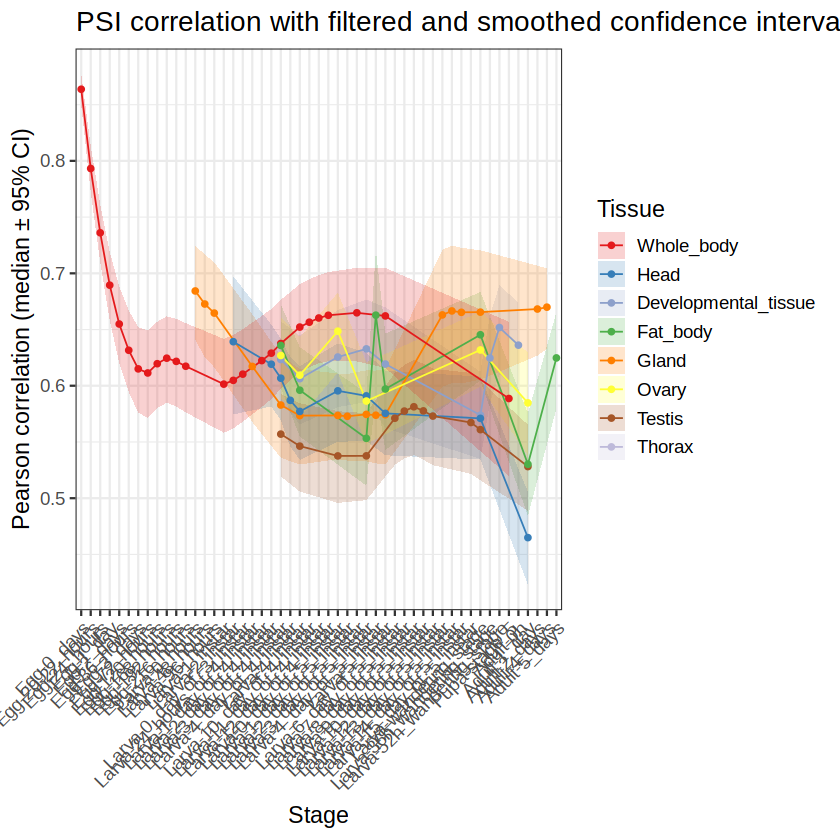

In [74]:
p <- ggplot(cor_all_smoothed, aes(x = Combined_Stage, y = cor_median_smooth, group = Tissue)) +
  geom_ribbon(aes(ymin = cor_lower_smooth, ymax = cor_upper_smooth, fill = Tissue), 
              alpha = 0.2, color = NA) +
  geom_line(aes(color = Tissue)) +  # 显式声明color映射
  geom_point(aes(color = Tissue)) + # 显式声明color映射
  theme_bw(base_size = 14) +
  labs(
    title = "PSI correlation with filtered and smoothed confidence intervals",
    x = "Stage",
    y = "Pearson correlation (median ± 95% CI)"
  ) +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1)
  ) +
  scale_fill_manual(
    values = tissue_color_mapping,
    breaks = names(tissue_color_mapping)
  ) +
  scale_color_manual(  # 新增颜色标度
    values = tissue_color_mapping,
    breaks = names(tissue_color_mapping)
  )
print(p)

In [ ]:
p <- # 用平滑后的数据进行绘图
  ggplot(cor_all_smoothed, aes(x = Combined_Stage, y = cor_median_smooth, group = Tissue, color = Tissue)) +
  geom_ribbon(aes(ymin = cor_lower_smooth, ymax = cor_upper_smooth, fill = Tissue), alpha = 0.2, color = NA) +
  geom_line() +
  geom_point() +
  theme_bw(base_size = 14) +
  labs(
    title = "PSI correlation with filtered and smoothed confidence intervals",
    x = "Stage",
    y = "Pearson correlation (median ± 95% CI)"
  ) +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1)
  )



In [ ]:
p <- ggplot(cor_all_smoothed, aes(x = as.numeric(Combined_Stage), y = cor_median_smooth, group = Tissue, color = Tissue)) +
  geom_ribbon(aes(ymin = cor_lower_smooth, ymax = cor_upper_smooth, fill = Tissue), alpha = 0.2, color = NA) +
  geom_line() +
  geom_point() +
  theme_bw(base_size = 14) +
  labs(
    title = "PSI correlation with filtered and smoothed confidence intervals",
    x = "Stage Index",  # 修改 x 轴标签为阶段索引
    y = "Pearson correlation (median ± 95% CI)"
  ) +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1)
  )

print(p)


In [ ]:
print(p)

In [77]:
ggsave("correlation_plot_2.pdf", p, width = 12, height = 6, dpi = 300)


Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range (`geom_line()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range (`geom_point()`).”
